In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go
from sklearn.tree import DecisionTreeRegressor
import dtreeviz
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os

### Prepara o dataset intermediário ###

In [7]:
src_type = "others"
model_ = "analysis"

dir_results = f"../../data/results/{src_type}"
dir_figures = f"{dir_results}/figures/{model_}"

if not os.path.exists(dir_figures):
    os.makedirs(dir_figures)

path_datasets = "../../data/datasets"
dataset = "Itaipu_POC_VAZAO_V1.csv"

## Número de Semanas Operativas Retroativas a serem utilizadas no Treinamento dos Algoritmos
n = 1 

In [8]:
semanas_operativas = pd.read_csv(f'{path_datasets}/{dataset}', index_col='time')
semanas_operativas

,bacia_prec_sum,vazao_itaipu
time,,
2001-01-06,188551.1250,96628.00
2001-01-13,431305.6250,113552.00
2001-01-20,199386.4375,84168.00
2001-01-27,337050.2500,81859.00
2001-02-03,369936.3125,98723.00
...,...,...
2020-12-05,314893.7500,37020.23
2020-12-12,381038.8750,46404.99
2020-12-19,362357.2500,63216.66


### Análises

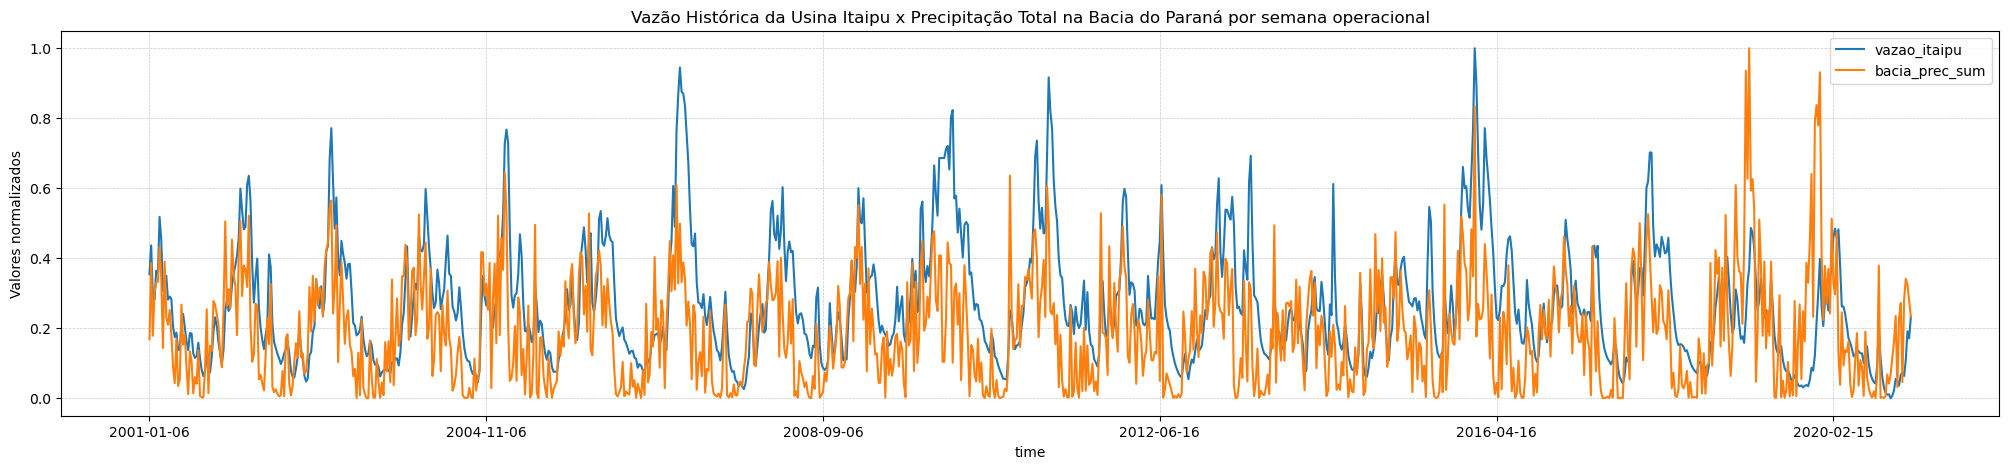

In [9]:
scaler = MinMaxScaler()

df = semanas_operativas[['vazao_itaipu','bacia_prec_sum']]

df_corr_normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

df_corr_normalized.plot(figsize=(25, 5), title='Vazão Histórica da Usina Itaipu x Precipitação Total na Bacia do Paraná por semana operacional', 
                        ylabel='Valores normalizados') #, color=['orange','blue']

plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

plt.savefig(f"{dir_figures}/history_vazao_vs_precBacia.png")
plt.show()

In [10]:
df = semanas_operativas[['vazao_itaipu','bacia_prec_sum']]

scaler = MinMaxScaler()
df_corr_normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=df_corr_normalized.index, 
        y=df_corr_normalized['vazao_itaipu'].values, 
        mode='lines', 
        name='Vazão Itaipu',
    )
)

fig.add_trace(
    go.Scatter(
        x=df_corr_normalized.index, 
        y=df_corr_normalized['bacia_prec_sum'].values, 
        mode='lines', 
        name='Precipitação na Bacia',
   )
)

fig.update_layout(
    title='Vazão Histórica da Usina Itaipu x Precipitação Total na Bacia do Paraná por semana operacional',
    xaxis=dict(title='Semana Operacional'),
    yaxis=dict(title='Valores normalizados'),
    autosize=False,
    width=1300,
    height=400,
    margin=dict(l=0, r=0, b=0, t=40),
    showlegend=True
)

fig.show()

### Calculando autocorrelações e correlação cruzada para precipitação e vazão observada

In [11]:
semanas_operativas.shape

(1047, 2)

In [12]:
# autocorrelação (definir até que ponto o n faz sentido) e correlação cruzada (tentar com as 2)
prec = semanas_operativas['bacia_prec_sum']
vazao = semanas_operativas['vazao_itaipu']

In [13]:
prec

time
2001-01-06    188551.1250
2001-01-13    431305.6250
2001-01-20    199386.4375
2001-01-27    337050.2500
2001-02-03    369936.3125
                 ...     
2020-12-05    314893.7500
2020-12-12    381038.8750
2020-12-19    362357.2500
2020-12-26    309619.8750
2021-01-02    259895.3125
Name: bacia_prec_sum, Length: 1047, dtype: float64

lag = 1


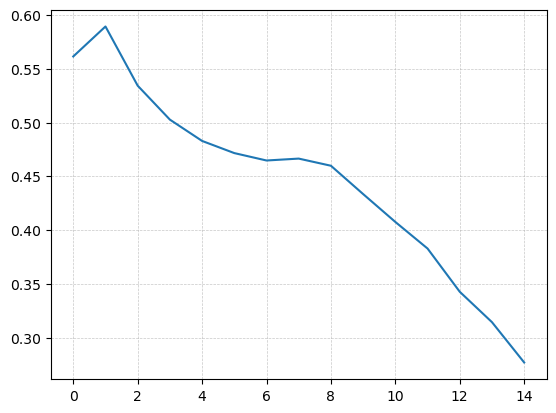

In [14]:
import statsmodels.api as sm

# A série 2 (vazão) é deslocada em relação a série 1 (precipitação), por isso:
serie2=vazao 
serie1=prec

## Calculando a correlação cruzada:
ccf_result = sm.tsa.ccf(serie2, serie1, adjusted=True)[:15]

lag = np.argmax(np.abs(ccf_result))

print(f'lag = {lag}') # 1 semana operativa

plt.plot(ccf_result)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.savefig(f"{dir_figures}/corr_cruzada_vazao_vs_prec.png")
plt.show()

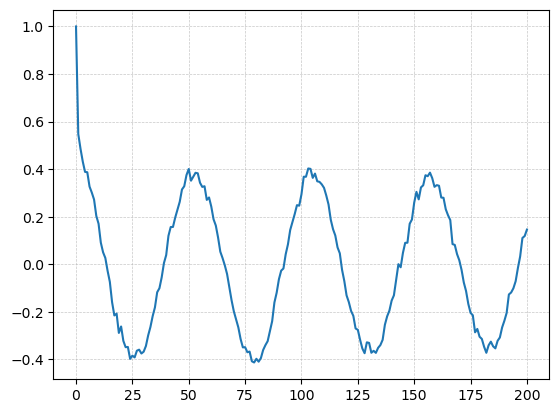

In [15]:
## Calculando a autocorrelação da precipitação
acf_result = sm.tsa.acf(prec, adjusted=True, nlags=200)

# lag = np.argmax(np.abs(acf_result))

# print(f'lag = {lag}') 

plt.plot(acf_result)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.savefig(f"{dir_figures}/autocorr_prec.png")
plt.show()

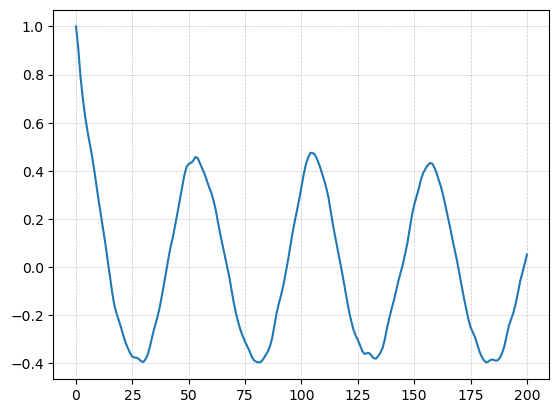

In [16]:
## Calculando a autocorrelação da vazão
acf_result = sm.tsa.acf(vazao, adjusted=True, nlags=200)

# lag = np.argmax(np.abs(acf_result))

# print(f'lag = {lag}') 

plt.plot(acf_result)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.savefig(f"{dir_figures}/autocorr_vazao.png")
plt.show()

### Analisando o Dataset de precipitacação x vazão observada 

In [17]:
df = semanas_operativas

for i in range(1, n+1):
    df[f'bacia_prec_sum (time - {i})'] = df['bacia_prec_sum'].shift(i)
    df[f'vazao_itaipu (time - {i})'] = df['vazao_itaipu'].shift(i)

df['bacia_prec_sum (time)'] = df['bacia_prec_sum']
df['vazao_itaipu (time)'] = df['vazao_itaipu']

df['bacia_prec_sum (time + 1)'] = df['bacia_prec_sum'].shift(-1)
df['vazao_itaipu (time + 1)'] = df['vazao_itaipu'].shift(-1)

df_poc = df.drop(columns=['bacia_prec_sum','vazao_itaipu']).copy()
df_poc = df_poc.dropna()
df_poc

,bacia_prec_sum (time - 1),vazao_itaipu (time - 1),bacia_prec_sum (time),vazao_itaipu (time),bacia_prec_sum (time + 1),vazao_itaipu (time + 1)
time,,,,,,
2001-01-13,188551.1250,96628.00,431305.6250,113552.00,199386.4375,84168.00
2001-01-20,431305.6250,113552.00,199386.4375,84168.00,337050.2500,81859.00
2001-01-27,199386.4375,84168.00,337050.2500,81859.00,369936.3125,98723.00
2001-02-03,337050.2500,81859.00,369936.3125,98723.00,371198.8125,96852.00
2001-02-10,369936.3125,98723.00,371198.8125,96852.00,482565.1250,130217.00
...,...,...,...,...,...,...
2020-11-28,303598.7500,37720.34,51492.6875,39122.11,314893.7500,37020.23
2020-12-05,51492.6875,39122.11,314893.7500,37020.23,381038.8750,46404.99
2020-12-12,314893.7500,37020.23,381038.8750,46404.99,362357.2500,63216.66


In [18]:
df_poc

,bacia_prec_sum (time - 1),vazao_itaipu (time - 1),bacia_prec_sum (time),vazao_itaipu (time),bacia_prec_sum (time + 1),vazao_itaipu (time + 1)
time,,,,,,
2001-01-13,188551.1250,96628.00,431305.6250,113552.00,199386.4375,84168.00
2001-01-20,431305.6250,113552.00,199386.4375,84168.00,337050.2500,81859.00
2001-01-27,199386.4375,84168.00,337050.2500,81859.00,369936.3125,98723.00
2001-02-03,337050.2500,81859.00,369936.3125,98723.00,371198.8125,96852.00
2001-02-10,369936.3125,98723.00,371198.8125,96852.00,482565.1250,130217.00
...,...,...,...,...,...,...
2020-11-28,303598.7500,37720.34,51492.6875,39122.11,314893.7500,37020.23
2020-12-05,51492.6875,39122.11,314893.7500,37020.23,381038.8750,46404.99
2020-12-12,314893.7500,37020.23,381038.8750,46404.99,362357.2500,63216.66


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


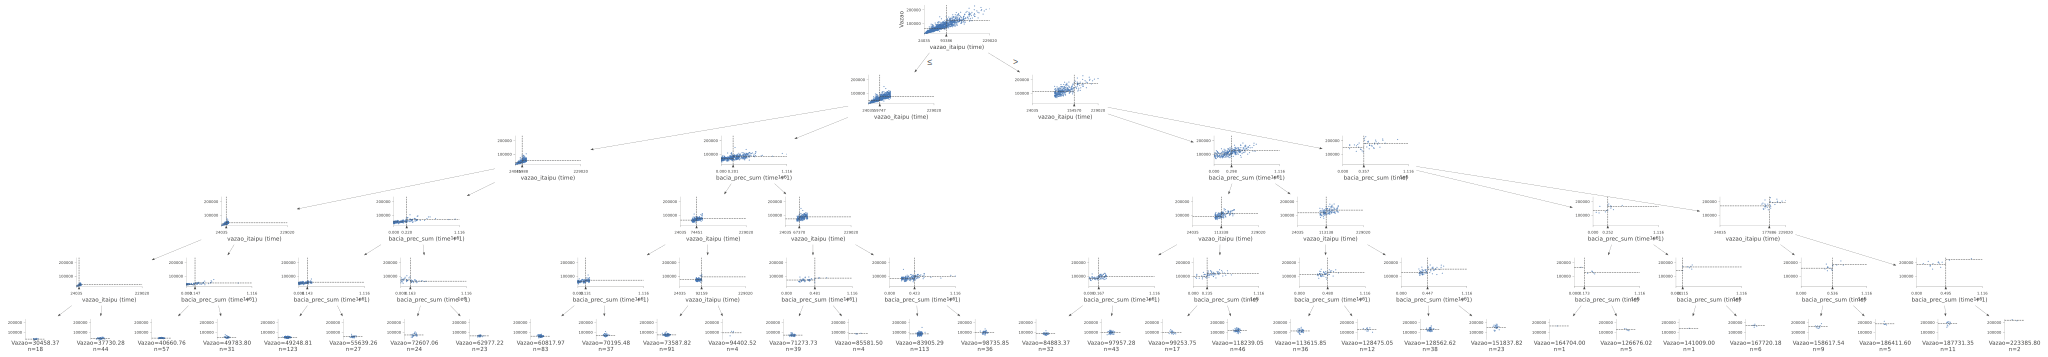

In [19]:
X_data = df_poc.iloc[3:-1,:-1].astype('float64').values
y_data = df_poc.iloc[3:-1,-1:].astype('float64').values

dt = DecisionTreeRegressor(
    criterion='squared_error',
    splitter='best',
    max_depth=5,
)

dt.fit(X_data, y_data)

viz_model = dtreeviz.model(
    dt,
    X_data,
    y_data,
    target_name='Vazao',
    feature_names=df_poc.columns[:-1],
)

v = viz_model.view()
v.save(f'{dir_figures}/dtreeviz.svg')
v

In [20]:
y_pred = dt.predict(X_data)

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=df_poc.iloc[3:-1,:-1].index,
        y=y_data.ravel(), # vazão observada
        mode='lines',
        name='Vazão observada',
    )
)

fig.add_trace(
    go.Scatter(
        x=df_poc.iloc[3:-1,:-1].index,
        y=y_pred.ravel(), # vazão prevista
        mode='lines',
        name='Forecast',
    )
)

fig.update_layout(title=f'Predição - Itaipu')
fig.write_image(f"{dir_figures}/history_measured_vs_predicted_plot.png", width=1400, scale=1)
fig.show()

In [21]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=y_data.flatten(),
        y=y_pred.flatten(),
        mode='markers',
        marker=dict(color='blue', opacity=0.5, line=dict(color='black', width=1)),
        name='Measured vs Predicted'
    )
)

fig.add_trace(
    go.Scatter(
        x=[y_data.min(), y_data.max()],
        y=[y_data.min(), y_data.max()],
        mode='lines',
        line=dict(color='red', dash='dash'),
        name='Identity Line'
    )
)

fig.update_layout(
    title='Measured vs Predicted',
    xaxis=dict(title='Measured'),
    yaxis=dict(title='Predicted'),
    autosize=False,
    width=800,
    height=500,
    margin=dict(l=0, r=0, b=0, t=40),
    showlegend=True
)

fig.write_image(f"{dir_figures}/scattered_measured_vs_predicted_plot.png")
fig.show()


In [22]:
mae = mean_absolute_error(y_data, y_pred)
mse = mean_squared_error(y_data, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_data, y_pred)
corr = np.corrcoef(y_data.T, y_pred.T)[0, 1]

metrics_df = pd.DataFrame(
    columns=['MAE', 'MSE', 'RMSE', 'R2', 'Corr'],
    index=['Decision Tree']
)

metrics_df['MAE'] = mae
metrics_df['MSE'] = mse
metrics_df['RMSE'] = rmse
metrics_df['R2'] = r2
metrics_df['Corr'] = corr
metrics_df

,MAE,MSE,RMSE,R2,Corr
Decision Tree,7276.651343,1.018049e+08,10089.842678,0.915597,0.956868


In [23]:
# plot feature importance sorted highest to lowest
feature_importance = {k: v for k, v in zip(df_poc.columns[:-1], dt.feature_importances_)}

feature_importance = dict(sorted(feature_importance.items(), key=lambda item: item[1], reverse=True))

fig = go.Figure(data=[
    go.Bar(name='Feature Importance', x=list(feature_importance.keys()), y=list(feature_importance.values())),
])

fig.update_layout(title=f'Feature Importance - Itaipu')
fig.write_image(f"{dir_figures}/dt_feature_importance_plot.png", width=1400, scale=1)
fig.show()
